In [ ]:
from data_load import *
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


# 数据读取

In [ ]:
# 设置参数
subject = 'sub-01'
img = 'Schaefer1000'

# 加载数据
bold_files_wm = load_fmri_data(subject, 'wm',img)
volume_labels_wm = load_labels_data('wm',img)
bold_files_emotion = load_fmri_data(subject, 'emotion',img)
volume_labels_emotion = load_labels_data('emotion',img)

final_bold_files = np.concatenate((bold_files_wm, bold_files_emotion), axis=0)
final_volume_labels = np.concatenate((volume_labels_wm, volume_labels_emotion), axis=0)

成功加载fMRI数据: /Users/zhangyexin/Documents/hcptrt-output/fMRI/Schaefer1000/wm/sub-01_wm_final_fMRI.npy
数据形状: (2037, 1000)
成功加载标签数据: /Users/zhangyexin/Documents/hcptrt-output/fMRI/Schaefer1000/wm/wm_final_labels.csv
标签形状: (2037, 1)
前5个标签:
             0
0  2-Back_Body
1  2-Back_Body
2  2-Back_Body
3  2-Back_Body
4  2-Back_Body
成功加载fMRI数据: /Users/zhangyexin/Documents/hcptrt-output/fMRI/Schaefer1000/emotion/sub-01_emotion_final_fMRI.npy
数据形状: (640, 1000)
成功加载标签数据: /Users/zhangyexin/Documents/hcptrt-output/fMRI/Schaefer1000/emotion/emotion_final_labels.csv
标签形状: (640, 1)
前5个标签:
                0
0  response_shape
1  response_shape
2  response_shape
3  response_shape
4  response_shape


# 数据集分割

In [33]:
X = final_bold_files
y = final_volume_labels

# 找到唯一的条件/类别
# 从标签数据 y 中找出所有独特的类别名称
categories = np.unique(y)
unique_conditions, order = np.unique(categories, return_index=True)
# 根据原始顺序对唯一条件进行排序
unique_conditions = unique_conditions[np.argsort(order)]

# 将字符串标签编码为数值
# 导入并创建 LabelEncoder 实例，用于将字符串标签转换为整数
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

# # 重塑 y 的形状
# # 将一维的 y 数组重塑为二维数组，使其形状为 (样本数量, 1)
# # 这是 OneHotEncoder 所需的输入格式
# y = np.reshape(y, (len(final_volume_labels), 1))

# # 创建 One-Hot-Encoder 实例
# # 导入并创建 OneHotEncoder 实例，用于进行独热编码
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')

# # 对 y 进行独热编码
# # 使用独热编码器对 y 进行拟合和转换
# import pandas as pd
# y = pd.DataFrame(enc.fit_transform(y).toarray())
# print('标签编码后的值:', y)

# 划分训练集和测试集
# 导入 train_test_split 函数
from sklearn.model_selection import train_test_split
# 将数据 X 和标签 y 随机划分为训练集和测试集，测试集占总数据的 10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

# 特征标准化
# 导入 StandardScaler，用于对特征进行标准化处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 使用训练集 X_train 拟合（fit）标准化参数（均值和标准差），然后转换（transform）X_train
X_train = scaler.fit_transform(X_train)
# 使用在训练集上拟合好的 scaler 对测试集 X_test 进行转换
X_test = scaler.transform(X_test)

# 获取类别的数量
num_cond = len(np.unique(y))

/opt/miniconda3/envs/hcptrt_decoding/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
print(unique_conditions)
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_val))
print(np.shape(y_val))
print(np.shape(X_test))
print(np.shape(y_test))

['0-Back_Body' '0-Back_Face' '0-Back_Place' '0-Back_Tools' '2-Back_Body'
 '2-Back_Face' '2-Back_Place' '2-Back_Tools' 'response_face'
 'response_shape']
(2168, 1000)
(2168,)
(241, 1000)
(241,)
(268, 1000)
(268,)


# ANN

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

In [36]:
# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
X_train_tensor = torch.from_numpy(X_train).float()  # 输入数据
y_train_tensor = torch.from_numpy(y_train).long()  # 类别标签
X_val_tensor = torch.from_numpy(X_val).float()  
y_val_tensor = torch.from_numpy(y_val).long()  
X_test_tensor = torch.from_numpy(X_test).float()  
y_test_tensor = torch.from_numpy(y_test).long()  

# 创建数据集
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=None, dropout_rate=0.3):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 222)
        self.fc2 = nn.Linear(222, 111)
        self.fc3 = nn.Linear(111, 55)
        self.out = nn.Linear(55, num_classes)

        # Dropout 层
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        logits = self.out(x)
        return logits


In [39]:
# 实例化模型
model = SimpleClassifier(input_dim=1000, num_classes=num_cond, dropout_rate=0.5).to(device)
# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# 训练设置
epochs = 50
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

In [41]:
for epoch in range(1, epochs + 1):
    # 训练模式
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()  # 清零梯度
        logits = model(xb)  # 前向传播
        loss = criterion(logits, yb)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        running_loss += loss.item() * xb.size(0)  # 计算累计损失
        preds = torch.argmax(logits, dim=1)  # 预测类别
        correct += (preds == yb).sum().item()  # 正确的预测数
        total += yb.size(0)  # 总样本数

    # 计算训练集损失和精度
    train_loss = running_loss / total
    train_acc = correct / total
    
    # 验证模式
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # 评估阶段不需要计算梯度
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_running_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    # 计算验证集损失和精度
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # 保存历史记录
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # 打印当前 epoch 的训练和验证结果
    print(f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 0.6233, Acc: 0.8100 | Val Loss: 0.8177, Acc: 0.7552
Epoch 2/50 | Train Loss: 0.5746, Acc: 0.8164 | Val Loss: 0.8037, Acc: 0.7801
Epoch 3/50 | Train Loss: 0.5752, Acc: 0.8220 | Val Loss: 0.7674, Acc: 0.7676
Epoch 4/50 | Train Loss: 0.5767, Acc: 0.8109 | Val Loss: 0.7735, Acc: 0.7801
Epoch 5/50 | Train Loss: 0.5363, Acc: 0.8298 | Val Loss: 0.7576, Acc: 0.7552
Epoch 6/50 | Train Loss: 0.5180, Acc: 0.8386 | Val Loss: 0.7637, Acc: 0.7676
Epoch 7/50 | Train Loss: 0.5034, Acc: 0.8409 | Val Loss: 0.7713, Acc: 0.7552
Epoch 8/50 | Train Loss: 0.5235, Acc: 0.8376 | Val Loss: 0.7151, Acc: 0.8008
Epoch 9/50 | Train Loss: 0.5701, Acc: 0.8150 | Val Loss: 0.7686, Acc: 0.7801
Epoch 10/50 | Train Loss: 0.5294, Acc: 0.8367 | Val Loss: 0.7687, Acc: 0.7842
Epoch 11/50 | Train Loss: 0.4535, Acc: 0.8506 | Val Loss: 0.9227, Acc: 0.7718
Epoch 12/50 | Train Loss: 0.5016, Acc: 0.8436 | Val Loss: 0.8144, Acc: 0.8050
Epoch 13/50 | Train Loss: 0.5144, Acc: 0.8349 | Val Loss: 0.8020, Acc: 0.

In [ ]:
# 测试集
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0
test_preds = []
test_labels = []
# 初始化用于存储每个类别的准确率
accuracies_per_condition = []
with torch.no_grad():  # 评估阶段不需要计算梯度
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        test_running_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == yb).sum().item()
        test_total += yb.size(0)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(yb.cpu().numpy())

        # 获取每个条件/类别的准确率
    for condition in np.unique(yb.cpu().numpy()):
        # 获取该类别的所有预测结果和真实标签
        condition_mask = (yb == condition)
        condition_preds = preds[condition_mask]
        condition_true = yb[condition_mask]

        # 计算该类别的准确率
        condition_accuracy = (condition_preds == condition_true).sum().item() / condition_true.size(0)
        accuracies_per_condition.append(condition_accuracy)
        
# 计算验证集损失和精度
test_loss = test_running_loss / test_total 
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f})")

Test Loss: 0.6596, Acc: 0.8321)


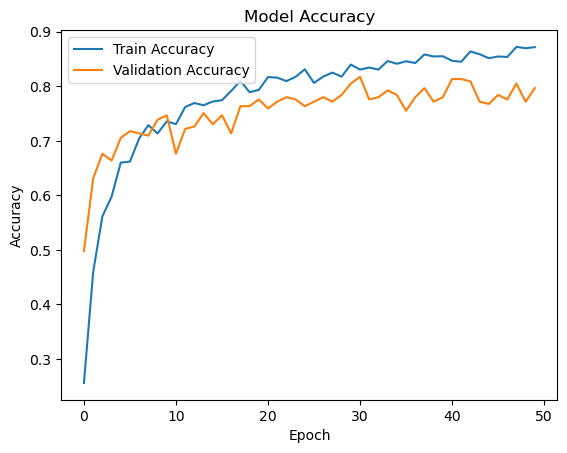

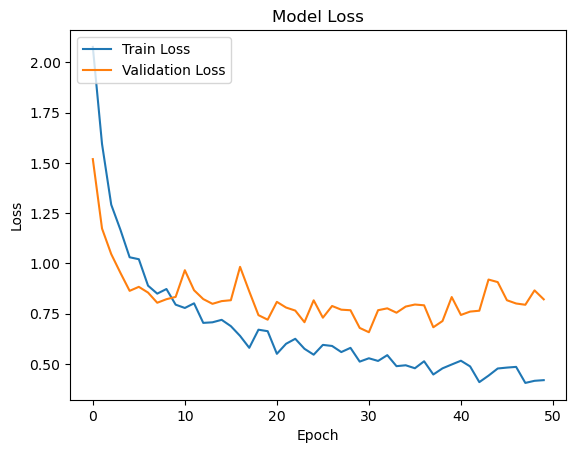

In [ ]:

plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


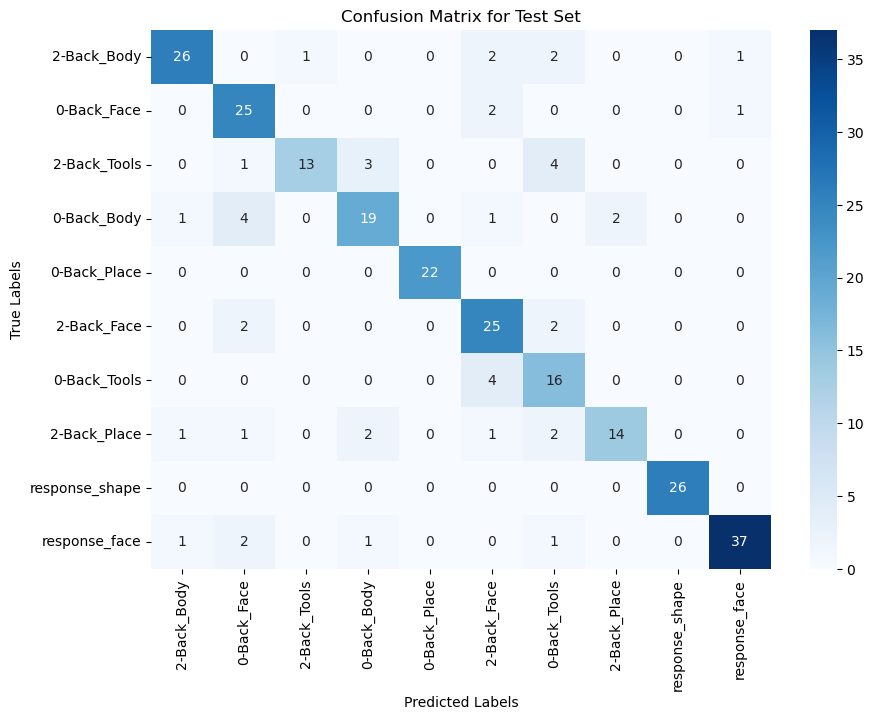

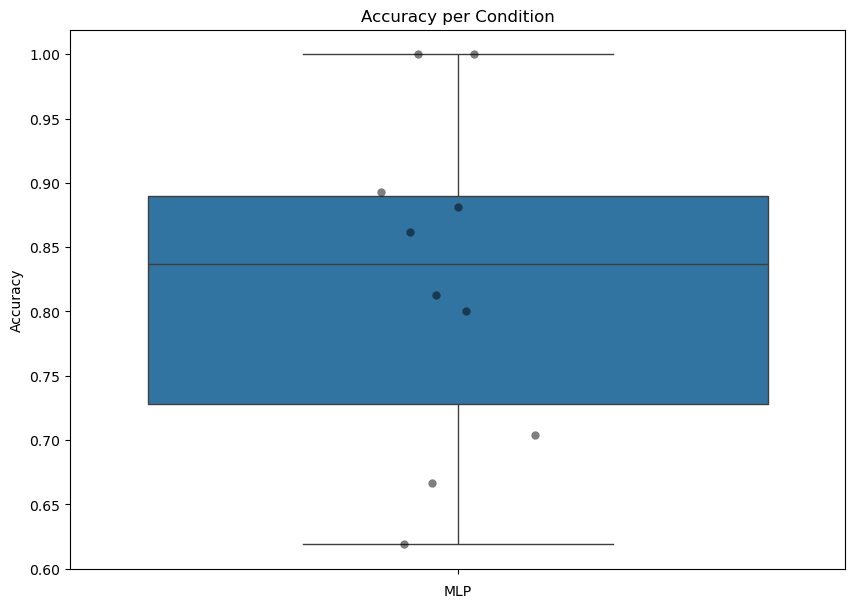

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd

# 计算混淆矩阵
cm = confusion_matrix(test_labels, test_preds)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_conditions, yticklabels=unique_conditions)
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 将预测结果和标签转换为 DataFrame
results_df = pd.DataFrame({
    'true_labels': test_labels,
    'predicted_labels': test_preds
})

# 初始化用于存储每个类别的准确率
accuracies_per_condition = []
# 绘制箱线图
plt.figure(figsize=(10, 7))
sns.boxplot(data=accuracies_per_condition)
# 添加每个点（stripplot）
sns.stripplot(data=accuracies_per_condition, color='black', alpha=0.5, jitter=True, size=6)
plt.title('Accuracy per Condition')
plt.xlabel('MLP')
plt.ylabel('Accuracy')
plt.show()

# SVM